In [ ]:
!python -m pip install -r requirements.txt
! pip install statsmodels

In [ ]:
!pip list


In [1]:
import sys 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



In [ ]:
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import statsmodels.api as sm

## Загрузка данных

Здесь данные пользователей онлайн-курсов. Все студенты сдали курс. 

Переменные:
* 'was_pay' - была ли оплата
* 'watch_unique' - сколько видео посмотрел на обучающей платформе
* 'q_n' - сколько вопросов написал на форуме
* 'ans_n' - сколько ответов написал на форуме
* 'vis_p' - сколько страниц и сколько раз посетил на форуме
* 'duration' - длительность прохождения курса

Эти переменные показывают действия студентов на сайте и описывают студентов лучше любых опросов. 

In [4]:
with open('students.csv', 'r') as file:
    raw_data = pd.read_csv(file)
raw_data.columns

Index(['course_id', 'hse_user_id', 'course_passing_state_id',
       'course_grade_overall', 'course_grade_ts', 'course_membership_ts',
       'vis_p', 'vis_b', 'course_slug', 'q_n', 'ans_n', 'watch_all',
       'watch_unique', 'video_n', 'what_pay', 'was_pay', 'is_prog_n',
       'is_prog_b', 'is_math_n', 'is_math_b', 'is_peer_n', 'is_peer_b',
       'duration', 'course_name', 'lang', 'field', 'spec', 'spec_b'],
      dtype='object')

In [3]:

data = raw_data.query('course_slug == "python-osnovy-programmirovaniya"')
data = data[['was_pay', 'watch_unique', 'q_n', 'ans_n', 'vis_p', 'duration']].reset_index(drop=True)


In [51]:
data.head(10)

,was_pay,watch_unique,q_n,ans_n,vis_p,duration,cluster
0,0,1,0,0,70,69.0,1
1,0,56,0,0,803,563.0,0
2,1,50,0,0,981,693.0,0
3,0,45,0,5,353,40.0,1
4,1,55,0,0,299,54.0,1
5,1,44,0,0,809,30.0,0
6,0,59,0,0,404,85.0,1
7,1,10,0,0,13,304.0,1
8,1,47,2,2,581,51.0,0
9,0,54,0,0,792,122.0,0


In [50]:
data.shape

(5962, 7)

## Кластеризация

Идея: кластеризуем студентов по всем указанным выше переменным и поймем как принадлежность к кластеру влияет на вероятность оплатить курс. 
Кластер должен выявить сложный паттерн действия студента. Например, кто-то смотрит много видео и часто заходит на форум. Кто-то не смотрит много видео и частно заходит на форум. И т.д.

In [60]:
model = KMeans(n_clusters=4)
model.fit(data.drop('was_pay', axis=1))
all_predictions = model.predict(data.drop('was_pay', axis=1))
print(all_predictions)



[0 3 1 ... 0 1 0]


## Визуализация кластеров

In [17]:
data.loc[:,'cluster'] = pd.Series(all_predictions)

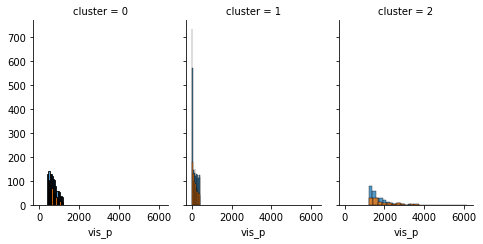

In [67]:
g = sns.FacetGrid(data, col="cluster",  hue = "was_pay", height=3.5, aspect=.65)
g.map(sns.histplot, "vis_p")


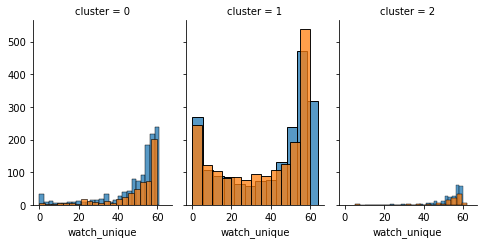

In [68]:
g = sns.FacetGrid(data, col="cluster",  hue = "was_pay", height=3.5, aspect=.65)
g.map(sns.histplot, "watch_unique")

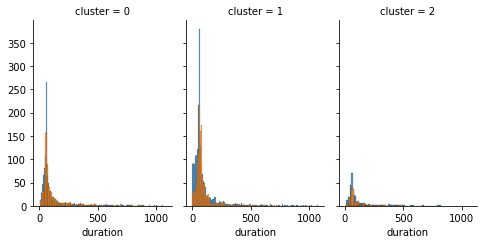

In [20]:
g = sns.FacetGrid(data, col="cluster",  hue = "was_pay", height=3.5, aspect=.65)
g.map(sns.histplot, "duration")

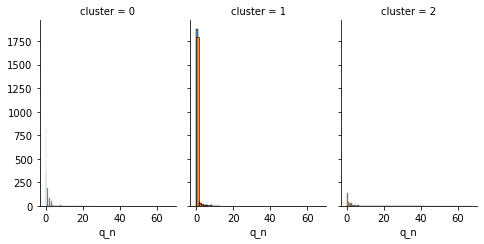

In [21]:
g = sns.FacetGrid(data, col="cluster",  hue = "was_pay", height=3.5, aspect=.65)
g.map(sns.histplot, "q_n")

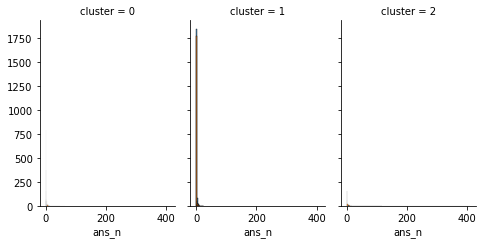

In [22]:
g = sns.FacetGrid(data, col="cluster",  hue = "was_pay", height=3.5, aspect=.65)
g.map(sns.histplot, "ans_n")

Видим три кластера:
* 0 - смотрят меньше среднего видео, средне посещают форум, на форуме не пишут
* 1 - смотрят много видео, мало посещают форум, часто пишут вопросы и ответы
* 2 - смотрят мало видео, часто посещают форум, на форуме не пишут

## Строим логистическую регрессию

Логистическая регрессия была выбрана, поскольку зависимая переменная (была оплата или нет) имеет только два значения (да, нет)

In [70]:
model = LogisticRegression(solver='liblinear', random_state=0)

X = data[['cluster']]
y = data['was_pay']
model.fit(X, y)


LogisticRegression(random_state=0, solver='liblinear')

In [71]:
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.690308
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                was_pay   No. Observations:                 5962
Model:                          Logit   Df Residuals:                     5961
Method:                           MLE   Df Model:                            0
Date:                Wed, 09 Jun 2021   Pseudo R-squ.:                -0.01299
Time:                        15:26:51   Log-Likelihood:                -4115.6
converged:                       True   LL-Null:                       -4062.8
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
cluster       -0.1615      0.028     -5.802      0.000      -0.216      -0.107


Видим, что кластеры значимо предсказывают оплату курса. Чтобы взяглнуть какой кластер влиял сильнее - сделаем график

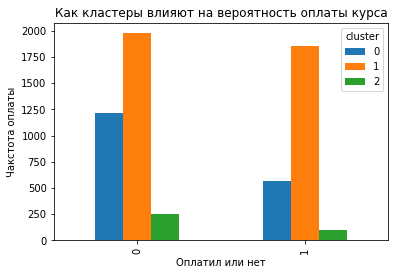

In [65]:
pd.crosstab(data.was_pay,data.cluster).plot(kind='bar')
plt.title('Как кластеры влияют на вероятность оплаты курса')
plt.xlabel('Оплатил или нет')
plt.ylabel('Частота оплаты')
plt.savefig('was_pay_bar')


Вывод: чаще всего форум оплачивают представители кластера 1, которые много уделяют времени видео, часто пишут на форуме, но посещают его реже остальных